Video explicativo [https://youtu.be/AJqLk4-tzcc?si=uKwqcwN2ePdU9ccP]

# Tema 7: Shor en 2n+3 qubits

Curso IAC02.

Autor: Alejandro Mata Ali

En este notebook vamos a implementar el algoritmo de Shor en 2n+3 qubits.

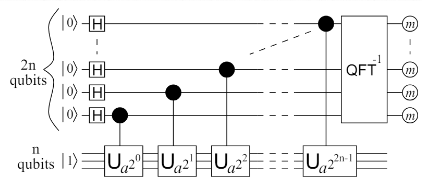

Este notebook implementará el algoritmo de Shor mediante la Quantum Phase Estimation with QFT (QPEwQFT) y mediante la Iterative Quantum Phase Estimation (IQPE).

El paper básico que se sigue en la creación de puertas es: https://arxiv.org/abs/quant-ph/0205095, de Stéphane Beauregard.[1]

Una explicación del algoritmo de Shor: https://hmong.es/wiki/Shor%27s_algorithm [2]

Explicación del IQPE:
https://doi.org/10.48550/arXiv.quant-ph/0001066 [3]

Explicación seminario del autor: https://youtu.be/AJqLk4-tzcc

## Librerías

In [1]:
%%capture
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer-gpu

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.circuit.library import PhaseEstimation, QFT

---
# Funciones del anterior tema

In [3]:
def numbin(a, n):
    '''Funcion que convierte el numero decimal a en uno binario con n bits.

    Parametros:
    a : entero que queremos pasar a binario.
    n : entero del numero de bits que queremos para el binario.
    '''
    a = bin(a)[2:]#[-n:]         #Pasamos el numero a binario
    return '0'*(n-len(a)) + a#Añadimos los ceros a la izquierda necesarios para que tenga el numero de bits.

def m_inv(a, N):
    '''Funcion que implementa a modulo inverso de N.'''
    return pow(a, -1, N)

def primador(p, q, itmax = 100, used_a = []):
    '''Funcion que implementa el crear un numero N a partir de 2 primos
    y nos da un numero a valido para el algoritmo.
    itmax es el numero de iteraciones permitidas para buscar este a.'''
    N   = p * q
    ver = True; itera = 0      #Comprueba que el maximo comun divisor de a y N sea 1.
    while ver and itera<itmax:
        a  = np.random.randint(2, N)#Entero aleatorio entre 2 y N.
        cd = np.gcd(a, N)
        if cd == 1 and (a not in used_a): ver = False
        itera += 1#Contador de iteraciones.
    if ver == True: raise ValueError('No se ha encontrado un a valido.')
    return a, N

def reductor(num, den):
    '''Esta función implementa la obtención de
    la fraccion irreducible de un numero.
    El número de entrada va a ser una fraccion num/den.
    Ambos parametros son enteros.
    Se basa en dividir entre todos los valores posibles.'''
    for i in range(num, 0, -1):
        if num % i == 0 and den % i == 0:
            num /= i; den /= i
    return int(num), int(den)

def procesador(counts, a, n, N):
    #Guardamos las claves y las frecuencias
    Keys = list(counts.keys())
    Frecuencias = [ counts[key] for key in Keys]
    #Ordenamos las claves segun su frecuencia
    Keys, Frecuencias = zip(*sorted(zip(Keys, Frecuencias)))
    #Convertimos las claves a entero
    Valores = [int(_, 2) for _ in Keys]

    for i in range(len(Valores)):#El 0 no contribuye.
        if Valores[i] != 0:
            r = reductor(Valores[i], 2**n)[0]#El denominador.
            if r % 2 == 0:
                if a**int(r/2) != -1 % N:
                    p_obt = np.gcd(a**int(r/2) - 1, N);   q_obt = np.gcd(a**int(r/2) + 1, N)
                    if N%p_obt == 0 and p_obt != N and p_obt != 1:#Si p es divisor
                        print('\nr = ', r, ', salida de cuentas: ', Valores[i], '. Puesto: ', i+1)
                        print('Los primos son: ', p_obt, ', ', N//p_obt)
                        return p_obt, N//p_obt
                        break
                    elif N%q_obt == 0 and q_obt != N and q_obt != 1:
                        print('\nr = ', r, ', salida de cuentas: ', Valores[i], '. Puesto: ', i+1)
                        print('Los primos son: ', q_obt, ', ', N//q_obt)
                        return q_obt, N//q_obt
                        break

    #Si no encontramos lo que debiamos
    return 1, 1

---
# Circuito cuántico

Para el circuito cuántico tendremos varios pasos, como indica el paper. Tendremos que hacer diversas funciones para ir haciendo las puertas necesarias. Cada función debe devolver una puerta directamente.

## Puerta Adición

La primera puerta que vamos a implementar es la puerta $\phi ADD(a)$, que transforma  $|\phi(b)\rangle$  en  $|\phi(b+a)\rangle$.

Esta será la puerta que haga la suma en el espacio de Fourier.

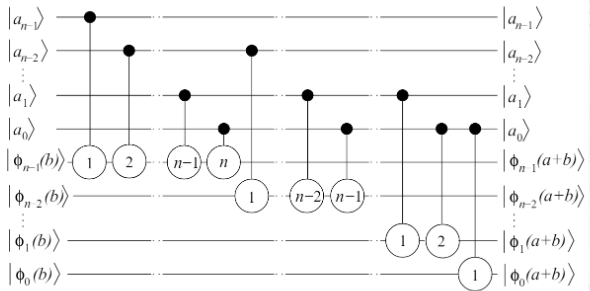

El funcionamiento de esta puerta es el siguiente:

* La entrada que recibe la puerta será la transformada cuántica de Fourier del número $b$ ( $\phi(b)$ ), y su salida será $\phi(b+a)$.
* Su parámetro de entrada será el número $a$ que queramos utilizar en formato binario con n bits. Es importante que tenga el mismo número de bits que la entrada $\phi(b)$, ya que se establece una relación 1 a 1 entre ellos.

* Creamos un grupo de ancillas para el número a y las inicializamos (con puertas X) para que sean el estado $| a_{n-1} a_{n-2} \dots a_1 a_0 \rangle$ siendo las $a_k$ las que cumplen $a = \sum_{k=0}^{n-1} a_k 2^{k}$.

¿Por qué usamos la transformada cuántica de Fourier?

Esto es debido a que en el espacio transformado, las fases sobre los estados son sumas sobre el espacio estándar. Por tanto, agregar una fase en $\phi(b)$ es lo mismo que sumar un número en $b$.

* Tras ello, aplicamos puertas de fase controladas sobre el qbit $|\phi_i\rangle$. Añadiremos controles desde los $|a_j\rangle$ con $j \geq i$ con una fase $\frac{\pi}{2^{j-i}}$. (Una forma de ahorrarse las ancillas y los controles es usar un if, ya que es un número clásico que entra como parámetro.)

* Finalmente restablecemos las ancillas y tenemos el estado $|\phi(b+a)\rangle$.

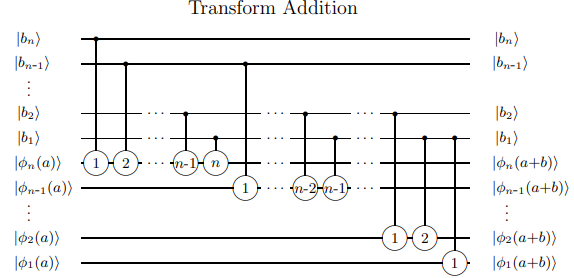

https://arxiv.org/abs/quant-ph/0008033

In [4]:
def ADDER_Gate(n:int, a:int):
    #Sacamos el binario de a
    binario = numbin(a,n)[::-1]#Al reves
    #Creamos el circuito con un registro
    qc = QuantumCircuit(n, name=f'ADD')

    #Hacemos para cada qubit objetivo
    for qubit in range(n):
        angle = 0
        for bit in range(qubit+1):#Para cada bit de a hasta lo necesario
            if binario[bit] == '1':
                angle += 2*np.pi/2**(1+(qubit-bit))

        qc.p(angle, qubit)

    #Creamos la puerta
    Gate = qc.to_gate()

    return Gate

Dibujamos la puerta.

a:7, N:15, n:4


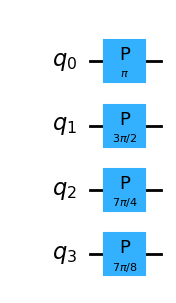

In [5]:
p, q = 3,5
a, N = primador(p, q)
n = int(np.ceil(np.log2(N)))
print(f'a:{a}, N:{N}, n:{n}')

qc = QuantumCircuit(n)
qc.append(ADDER_Gate(n,a), range(n))

qc.decompose(f'ADD').draw('mpl')

Vamos a hacer una prueba.

0111


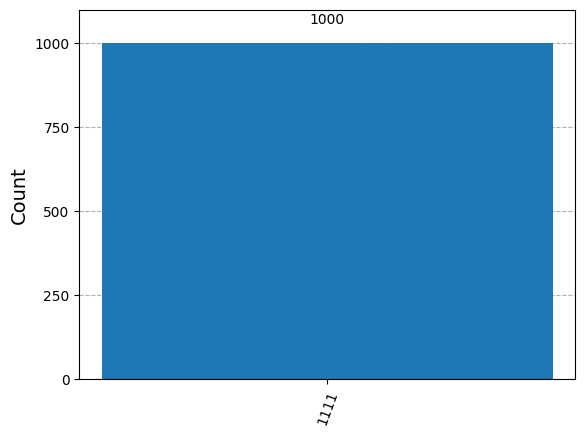

In [6]:
print(numbin(a,n))
w = 37
w %= 2**(n+1)
qc = QuantumCircuit(n)
qc.x(2)
qc.append(QFT(n, do_swaps=False), range(n))
qc.append(ADDER_Gate(n,w).inverse(), range(n))
qc.append(QFT(n, inverse=True, do_swaps=False), range(n))

qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# GenericBackendV2(num_qubits=qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [7]:
b = 4
res = (b-w)
res1 = 2**(n+1) - (w-b)

print(res)
print(res1)
print(bin(res))
print(bin(res1))

-1
31
-0b1
0b11111


## Puerta Adición modular condicionada

La segunda puerta que vamos a implementar es la puerta $\phi ADD(a)mod(N)$, que transforma  $|\phi(b)\rangle$  en  $|\phi(b+a)mod(N)\rangle$.

Esta puerta realiza la suma modular en el espacio de Fourier.

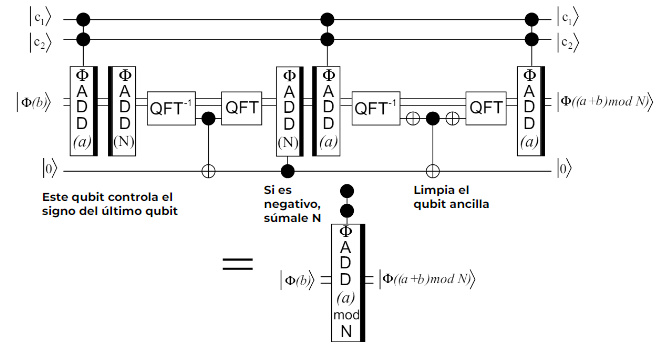

Esta puerta funciona siguiendo la siguiente lógica:
* La entrada será la transformada cuántica de Fourier del número $b$ ( $\phi(b)$ ), y su salida será $\phi(b+a) mod(N)$.
* Sus parámetros serán $a$ y $N$ en binario. El número $b$ debe tener un bit de más para evitar overflow y poder saber cual es el signo de cuentas intermedias.
* Primero sumamos $a$ teniendo $\phi(b+a)$ y procedemos a restarle $N$ con la inversa (dagger) de $\phi ADD(N)$, obteniendo $\phi(b+a-N)$.
* Ahora bien, tras esta última operación existe la posibilidad de que el número obtenido sea negativo, si $a+b\leq N$, por lo que miraremos el bit más significativo (el 0), para lo cual primero deberemos invertir la QFT.
* Como necesitamos usar ese bit posteriormente, lo guardamos en una ancilla con una puerta CNOT y rehacemos la QFT para seguir operando.
* Una vez hecho esto, si nuestro número era negativo, necesitamos deshacer la resta de $N$, ya que no queremos números negativos, por lo que usando la ancilla donde pusimos la información del signo, aplicaremos la suma de $N$ de forma controlada por este qbit.

* En principio ya tenemos $\phi(b+a) mod(N)$, pero necesitamos restaurar la ancilla, así que necesitamos saber si hemos restado $N$ anteriormente.
* Para ello restaremos $a$ y desharemos la QFT, lo cual nos dará el número $(a+b)mod N-a$ del cual sacaremos el signo, pero invertido. Esto es debido a que usamos la identidad: $(a+b)mod(N)\geq a \rightarrow (a+b)mod(N)- a \Longleftrightarrow a + b < N$. Por lo tanto, si el número obtenido es positivo será porque antes obtuvimos un número negativo.
* Por tanto, aplicamos una X sobre ese qbit, CNOT desde ese qbit a la ancilla, deshacemos la X, volvemos a QFT y volvemos a sumar la $a$ que habíamos restado.

In [8]:
def cc_Mod_ADDER_Gate(n:int, a:int, N:int):
    #Primero creamos la puerta Add con a y con N
    ADDER_Gate_a = ADDER_Gate(n+1,a%N)#Hay que sumar a mod N
    ADDER_Gate_N = ADDER_Gate(n+1,N)

    #Registros
    control = QuantumRegister(2, name='ctrl')
    state   = QuantumRegister(n+1, name='phi')#Uno extra para el overflow
    sign    = QuantumRegister(1, name='sign')#Ancilla del signo

    qc = QuantumCircuit(control, state, sign, name=f'cc_ADD_mod')

    #Añadimos las puertas de adición controlada y libre
    qc.append(ADDER_Gate_a.control(2), control[:]+state[:])
    qc.append(ADDER_Gate_N.inverse(), state)

    #Comprobamos el signo
    qc.append(QFT(n+1, inverse=True, do_swaps=False), state)
    qc.cx(state[-1], sign[0])
    qc.append(QFT(n+1, do_swaps=False), state)

    #Segunda tanda de sumas
    qc.append(ADDER_Gate_N.control(1), sign[:]+state[:])
    qc.append(ADDER_Gate_a.inverse().control(2), control[:]+state[:])

    #Corregimos la ancilla
    qc.append(QFT(n+1, inverse=True, do_swaps=False), state)
    qc.x(state[-1])
    qc.cx(state[-1], sign[0])
    qc.x(state[-1])
    qc.append(QFT(n+1, do_swaps=False), state)

    #Deshacemos
    qc.append(ADDER_Gate_a.control(2), control[:]+state[:])

    #Descomponemos las QFT
    qc_decomp = qc.decompose(['QFT', 'IQFT'], reps=1)

    #Transformamos a puerta
    Gate = qc_decomp.to_gate()

    return Gate

Visualizamos.

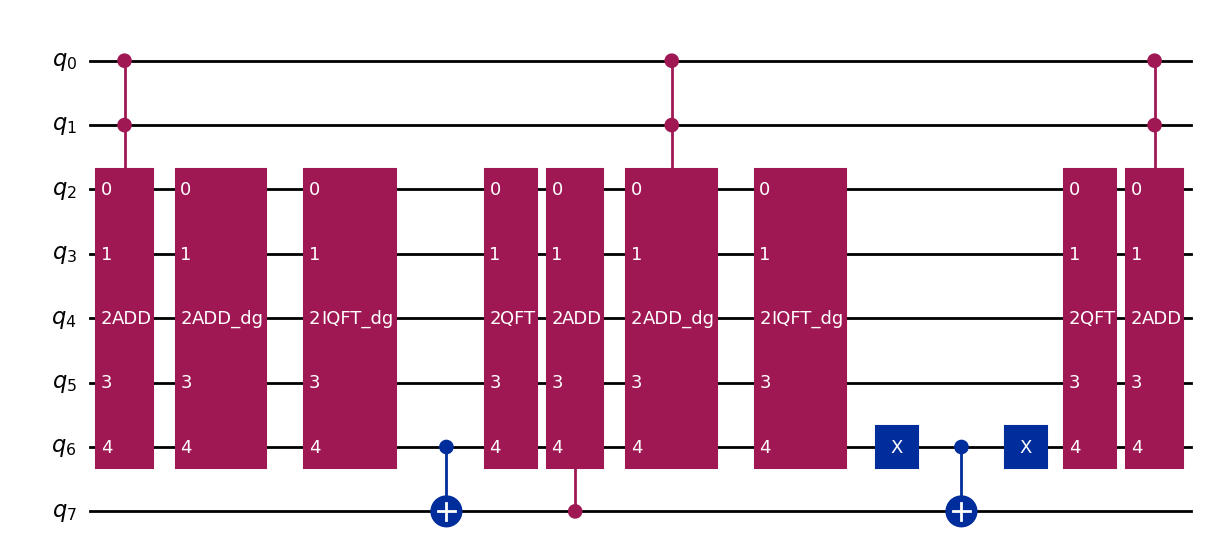

In [9]:
qc = QuantumCircuit(2+n+1+1)
qc.append(cc_Mod_ADDER_Gate(n,a,N), range(n+4))

qc.decompose([f'cc_ADD_mod'], reps=2).draw('mpl')

Probamos.

1010


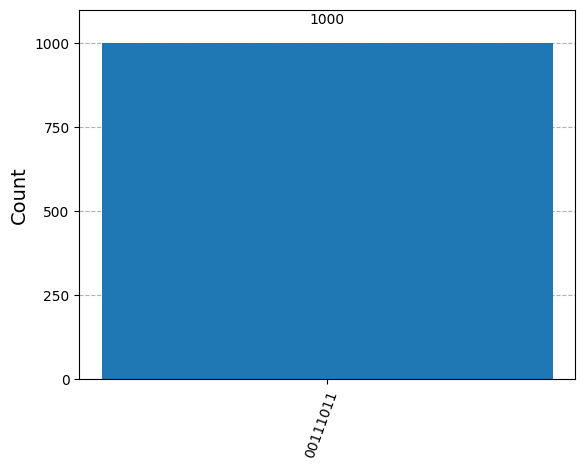

In [10]:
w = 26
print(numbin(w,n)[-n:])
control = QuantumRegister(2, name='ctrl')
state   = QuantumRegister(n+1, name='phi')#Uno extra para el overflow
sign    = QuantumRegister(1, name='sign')#Ancilla del signo

qc = QuantumCircuit(control, state, sign, name=f'cc_ADD_mod')

qc.x(control)#Activamos

qc.x(state[0])
qc.x(state[1])
qc.append(QFT(n+1, do_swaps=False), state)
qc.append(cc_Mod_ADDER_Gate(n,w,N), range(n+4))
qc.append(QFT(n+1, inverse=True, do_swaps=False), state)

qc.measure_all()
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# GenericBackendV2(num_qubits=qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [11]:
b = 3
res = (w+b)%N
print(res)
print(bin(res))

14
0b1110


## Puerta Multiplicación Modular condicionada

La tercera puerta que vamos a implementar es la puerta $\phi CMULT(a)mod(N)$, que transforma  $|x\rangle|\phi(b)\rangle$  en  $|x\rangle|\phi(b+a\cdot x)mod(N)\rangle$.

La puerta que hace la multiplicación.

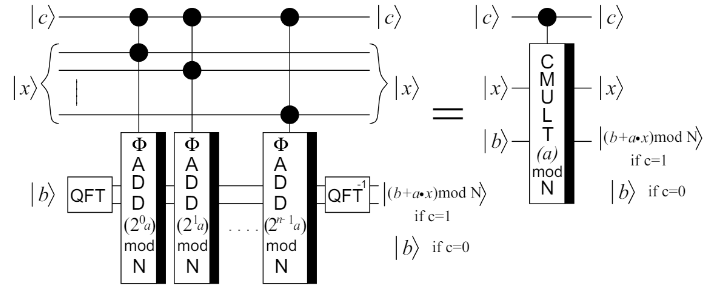

Esta puerta opera de la siguiente manera:
* Su objetivo es convertir $b$ en $(b+a\cdot x)mod(N)$, teniendo como entradas $|x\rangle$ y $|b\rangle$ y los parámetros $a$ y $N$ en forma de binarios. Es importante que $|x\rangle$ tenga el mismo número de qbits que $|b\rangle$, por la siguiente puerta.
* Lo primero que hacemos es transformar el número $b$ en su forma en QFT. Tras ello, vamos aplicando puertas $\phi ADD(2^j a)mod(N)$ sobre $|\phi(b)\rangle$ controladas por los qbits $|x_{n-1-j}\rangle$. La puerta $\phi ADD(2^j a)mod(N)$ significa aplicar $2^j$ veces la puerta $\phi ADD(a)mod(N)$ o aplicarla con el $a$ cambiado.
* Este paso es exactamente igual que la multiplicación usual con números binarios.
* Tras ello deshacemos la QFT y tenemos nuestro resultado.

Recordemos que utilizamos los números de entrada en el espacio estándar solamente en esta puerta, mientras que las que tiene dentro usan los números en el espacio transformado. Esto es debido a que de introducir también las QFT en esas puertas, tendríamos algo de la forma:

$QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}-\dots-QFT-ADD-QFT_{inv}-QFT-ADD-QFT_{inv}$,

donde obviamente las QFT desaparecen con sus inversas, por lo que nos podemos ahorrar todas esas puertas.

In [12]:
def CMULT_Gate(n:int, a:int, N:int):
    #Creamos el circuito con 3 registros
    control = QuantumRegister(1, name='ctrl')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')#El extra es solo abajo
    ancilla = QuantumRegister(1, name='anc')#El ancilla del signo

    qc = QuantumCircuit(control, qx, qb, ancilla, name=f'CMULT')

    #Aplicamos la QFT
    qc.append(QFT(n+1, do_swaps=False), qb)

    #Sumas controladas de cada qubit de x
    for i in range(n):
        qc.append(cc_Mod_ADDER_Gate(n,a*2**i,N), control[:]+[qx[i]]+qb[:]+ancilla[:])

    #QFT inversa
    qc.append(QFT(n+1, inverse=True, do_swaps=False), qb)

    qc_decomp = qc.decompose(['QFT', 'IQFT'], reps=1)

    #Transformamos a puerta
    Gate = qc_decomp.to_gate()

    return Gate

Visualizamos.

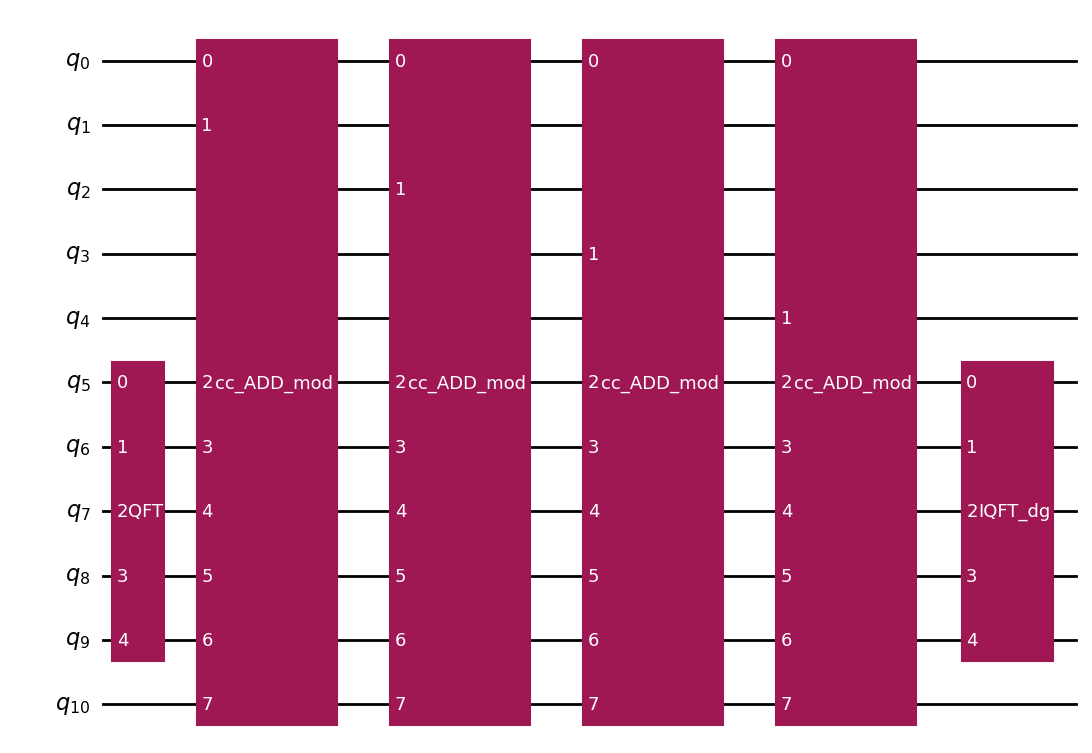

In [13]:
qc = QuantumCircuit(2*n+3)
qc.append(CMULT_Gate(n,a,N), range(2*n+3))

qc.decompose([f'CMULT'], reps=2).draw('mpl')

Probamos

0111


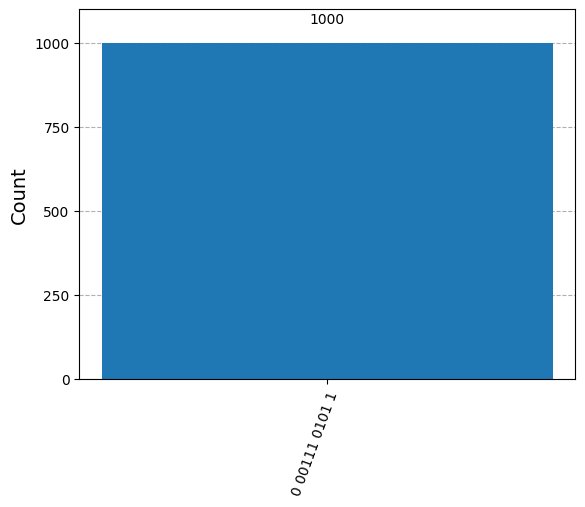

In [14]:
print(numbin(a,n))
control = QuantumRegister(1, name='ctrl')
qx      = QuantumRegister(n, name='x')
qb      = QuantumRegister(n+1, name='b')#El extra es solo abajo
ancilla = QuantumRegister(1, name='anc')#El ancilla del signo

crc = ClassicalRegister(1)
crx = ClassicalRegister(n)
crb = ClassicalRegister(n+1)
cra = ClassicalRegister(1)

qc = QuantumCircuit(control, qx, qb, ancilla, crc, crx, crb, cra)


qc.x(control)#Activamos

qc.x(qx[0])
qc.x(qx[2])

qc.x(qb[1])

qc.append(CMULT_Gate(n,a,N), range(2*n+3))

qc.measure(control,crc)
qc.measure(qx,crx)
qc.measure(qb,crb)
qc.measure(ancilla,cra)

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# GenericBackendV2(num_qubits=qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [15]:
b = 2
x = 5
res = (b+a*x)%N

print(res)
print(bin(res))

7
0b111


## Puerta U

Finalmente, implementamos la puerta general $U_a$ que nos convierte $|x\rangle$ en $|(a\cdot x)mod(N)\rangle$.

La puerta cuyos autovalores queremos.

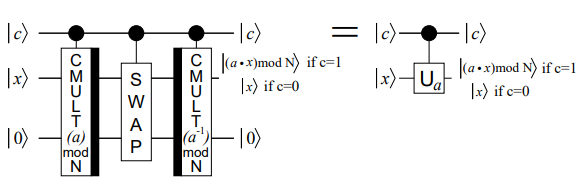

Esta puerta de Shor funciona de la siguiente manera:
* Esta puerta implementa pasar de $x$ a $(a\cdot x)mod(N)$. Su entrada es el vector $|x\rangle$ y los parámetros $a$ y $N$ en entero.
* Vamos a usar una ancilla inicializada a 0 para la parte inferior de la multiplicación (así el factor obtenido estará solamente multiplicado y no tendrá una suma).
* Primero hacemos la multiplicación por a, obteniendo $|x\rangle|(a\cdot x)mod(N)\rangle$.
* Como no queremos nada en la ancilla, aplicamos un SWAP entre la ancilla y la línea principal, obteniendo $|(a\cdot x)mod(N)\rangle|x\rangle$.
* Ahora hacemos la multiplicación por el inverso módulo $N$ de $a$ ($a^{-1}$) teniendo $|(a\cdot x)\rangle|(x- a^{-1}a\cdot x)mod(N)\rangle = |(a\cdot x)mod(N)\rangle|0\rangle$, que es lo que queríamos.

In [16]:
def U_Gate(n:int, a:int, N:int):
    #Cuatro registros como antes
    #Creamos el circuito con 3 registros
    control = QuantumRegister(1, name='ctrl')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    qc = QuantumCircuit(control, qx, qb, ancilla, name=f'U')

    #Multiplicamos
    qc.append(CMULT_Gate(n,a,N), control[:]+qx[:]+qb[:]+ancilla[:])

    #Hacemos todos los SWAPS entre qubits
    for i in range(n):
        qc.cswap(control[0], qx[i], qb[i])

    #Multiplicamos al revés con la inversa modulo N de a
    qc.append(CMULT_Gate(n,m_inv(a,N),N).inverse(), control[:]+qx[::]+qb[::]+ancilla[:])

    Gate = qc.to_gate()

    return Gate

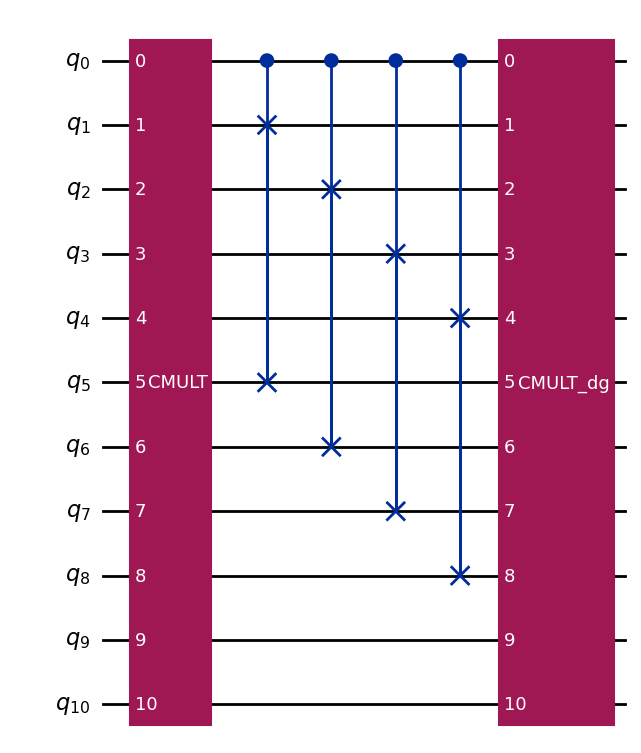

In [17]:
qc = QuantumCircuit(2*n+3)
qc.append(U_Gate(n,a,N), range(2*n+3))

qc.decompose([f'U'], reps=2).draw('mpl')

Hacemos la prueba

0111


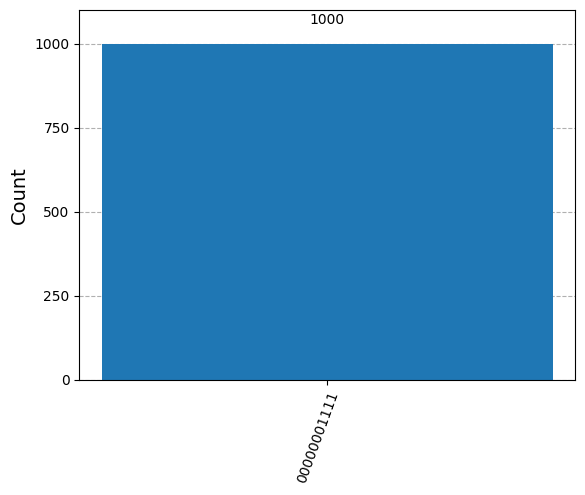

In [18]:
print(numbin(a,n))
control = QuantumRegister(1, name='ctrl')
qx      = QuantumRegister(n, name='x')
qb      = QuantumRegister(n+1, name='b')
ancilla = QuantumRegister(1, name='anc')
qc = QuantumCircuit(control, qx, qb, ancilla)

qc.x(control)#Activamos

qc.x(qx[0])
qc.append(U_Gate(n,a,N), range(2*n+3))

qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator()# GenericBackendV2(num_qubits=qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [19]:
x = 1
print(a*x%N)
print(numbin(a*x%N,n))

7
0111


## Phase Estimation

Construimos el circuito final.

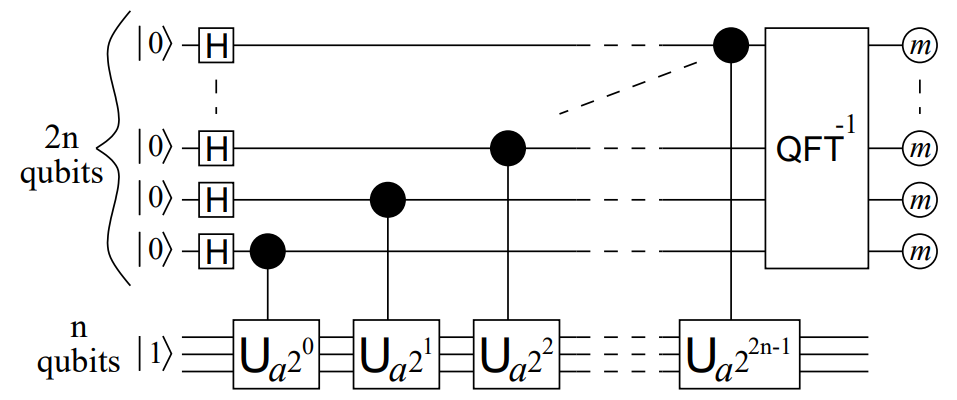

In [20]:
def Shor_Circuit(n:int, a:int, N:int):
    #Registros
    clock   = QuantumRegister(2*n, name='Clock')#para la QFT
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    cr      = ClassicalRegister(2*n, name='measure')

    qc = QuantumCircuit(clock, qx, qb, cr, ancilla, name='Shor')
    #Iniciamos en 1
    qc.x(qx[0])
    #La QPE
    for i in range(2*n):
        qc.h(clock[i])
        qc.append(U_Gate(n, int(a**(2**i)), N), [clock[i]]+qx[:]+qb[:]+ancilla[:])

    #QFT inversa
    qc.append(QFT(2*n, inverse=True, do_swaps=False), clock)
    #Medicion del clock
    qc.measure(clock, cr)

    qc_decomp = qc.decompose(['QFT', 'IQFT'], reps=1)

    return qc_decomp

Visualizamos.

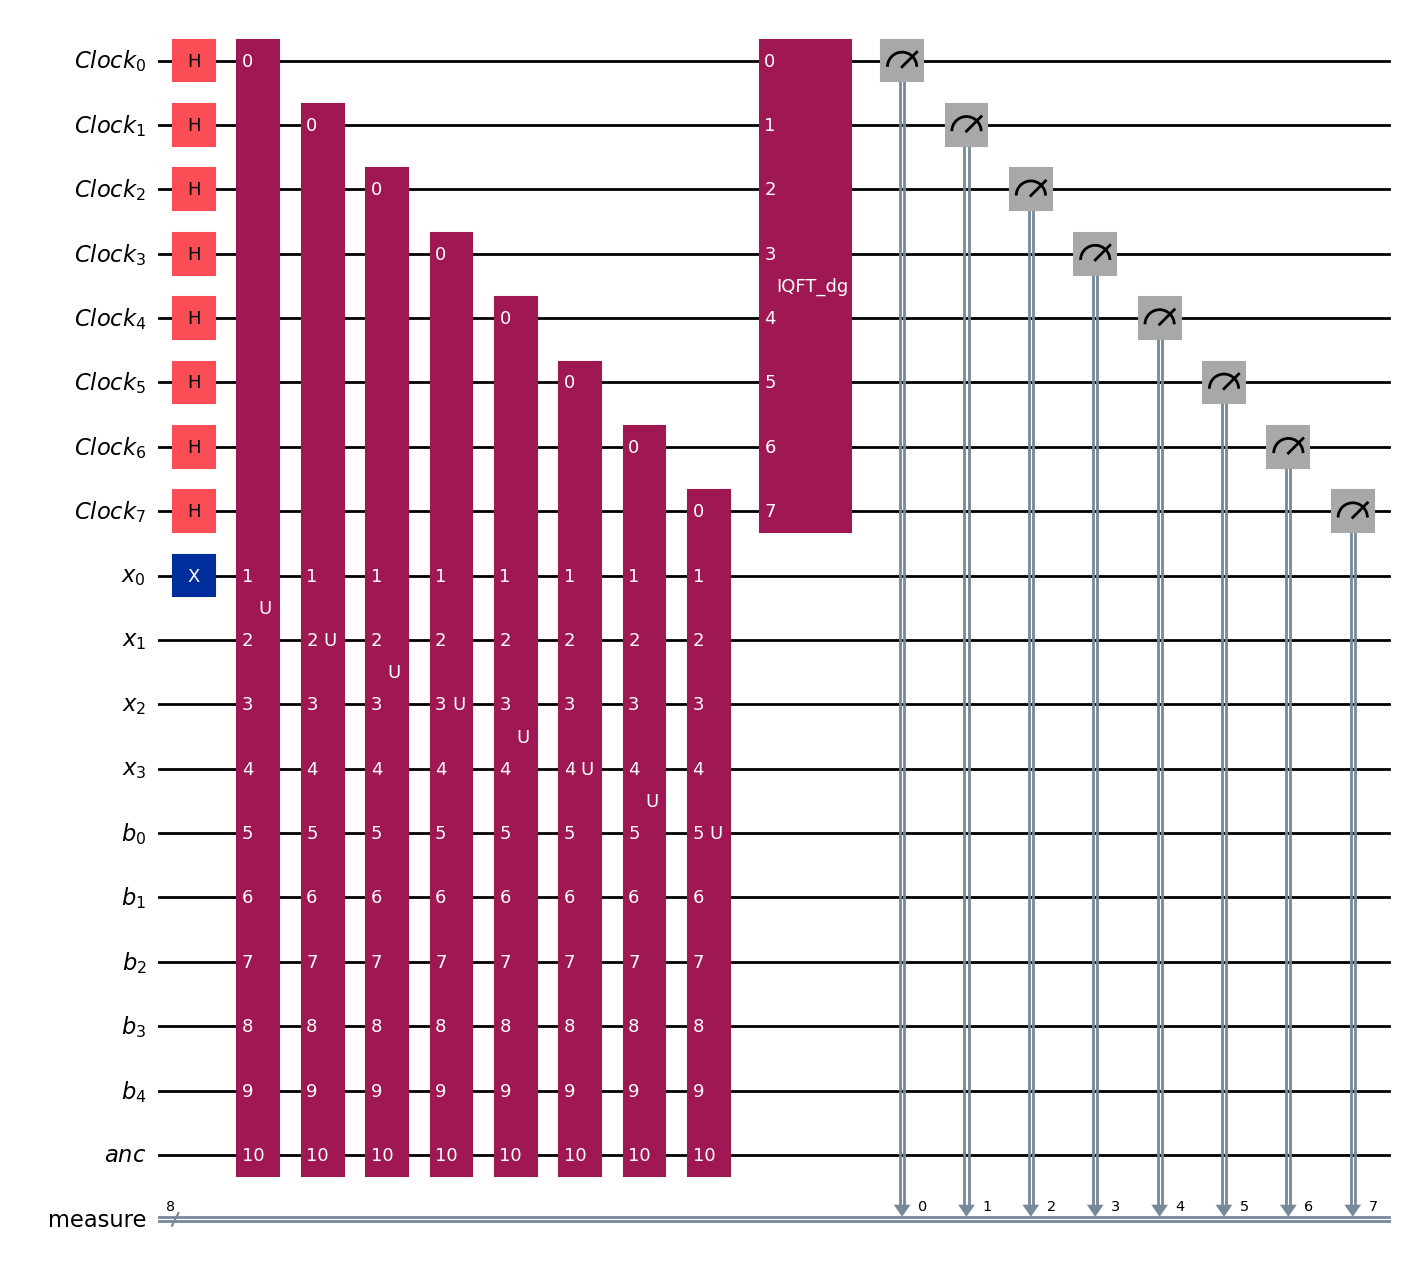

In [21]:
qc = Shor_Circuit(n,a,N)

qc.draw('mpl')

Sin embargo, tenemos que implementar las QPE iterativa concreta de este problema. 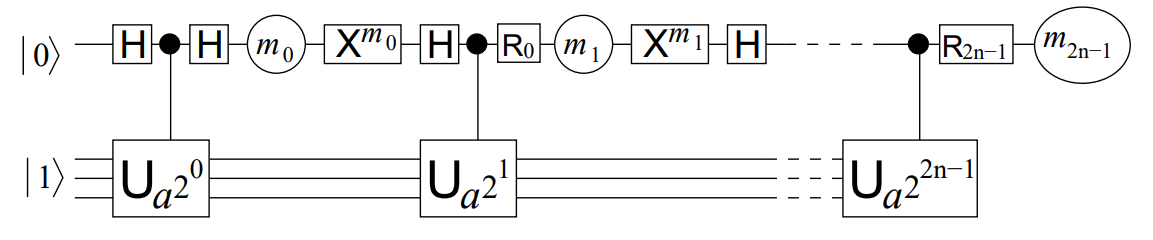

https://arxiv.org/abs/quant-ph/0001066

In [22]:
def Shor_Iterative_Circuit(n:int, a:int, N:int):
    #Registros
    clock   = QuantumRegister(1, name='Clock')
    qx      = QuantumRegister(n, name='x')
    qb      = QuantumRegister(n+1, name='b')
    ancilla = QuantumRegister(1, name='anc')

    #Necesitamos varios registros también para el tema de las puertas de fase
    cr      = ClassicalRegister(2*n, name='measure')

    qc = QuantumCircuit(clock, qx, qb, cr, ancilla, name='Shor')
    #Iniciamos en 1
    qc.x(qx[0])
    #La QPE
    for i in range(2*n):
        qc.h(clock)
        qc.append(U_Gate(n, int(a**(2**(2*n-1-i))), N), clock[:]+qx[:]+qb[:]+ancilla[:])#Va al reves la exponenciacion por el paper original
        #Puerta condicionada de las mediciones anteriores
        for k in range(1,i):
            with qc.if_test((cr[i-k],1)):
                qc.p(-2*np.pi/2**k, clock)

        qc.h(clock)
        qc.measure(clock,cr[i])
        #La corrección de la iteración
        with qc.if_test((cr[i],1)):
            qc.x(clock)

    return qc

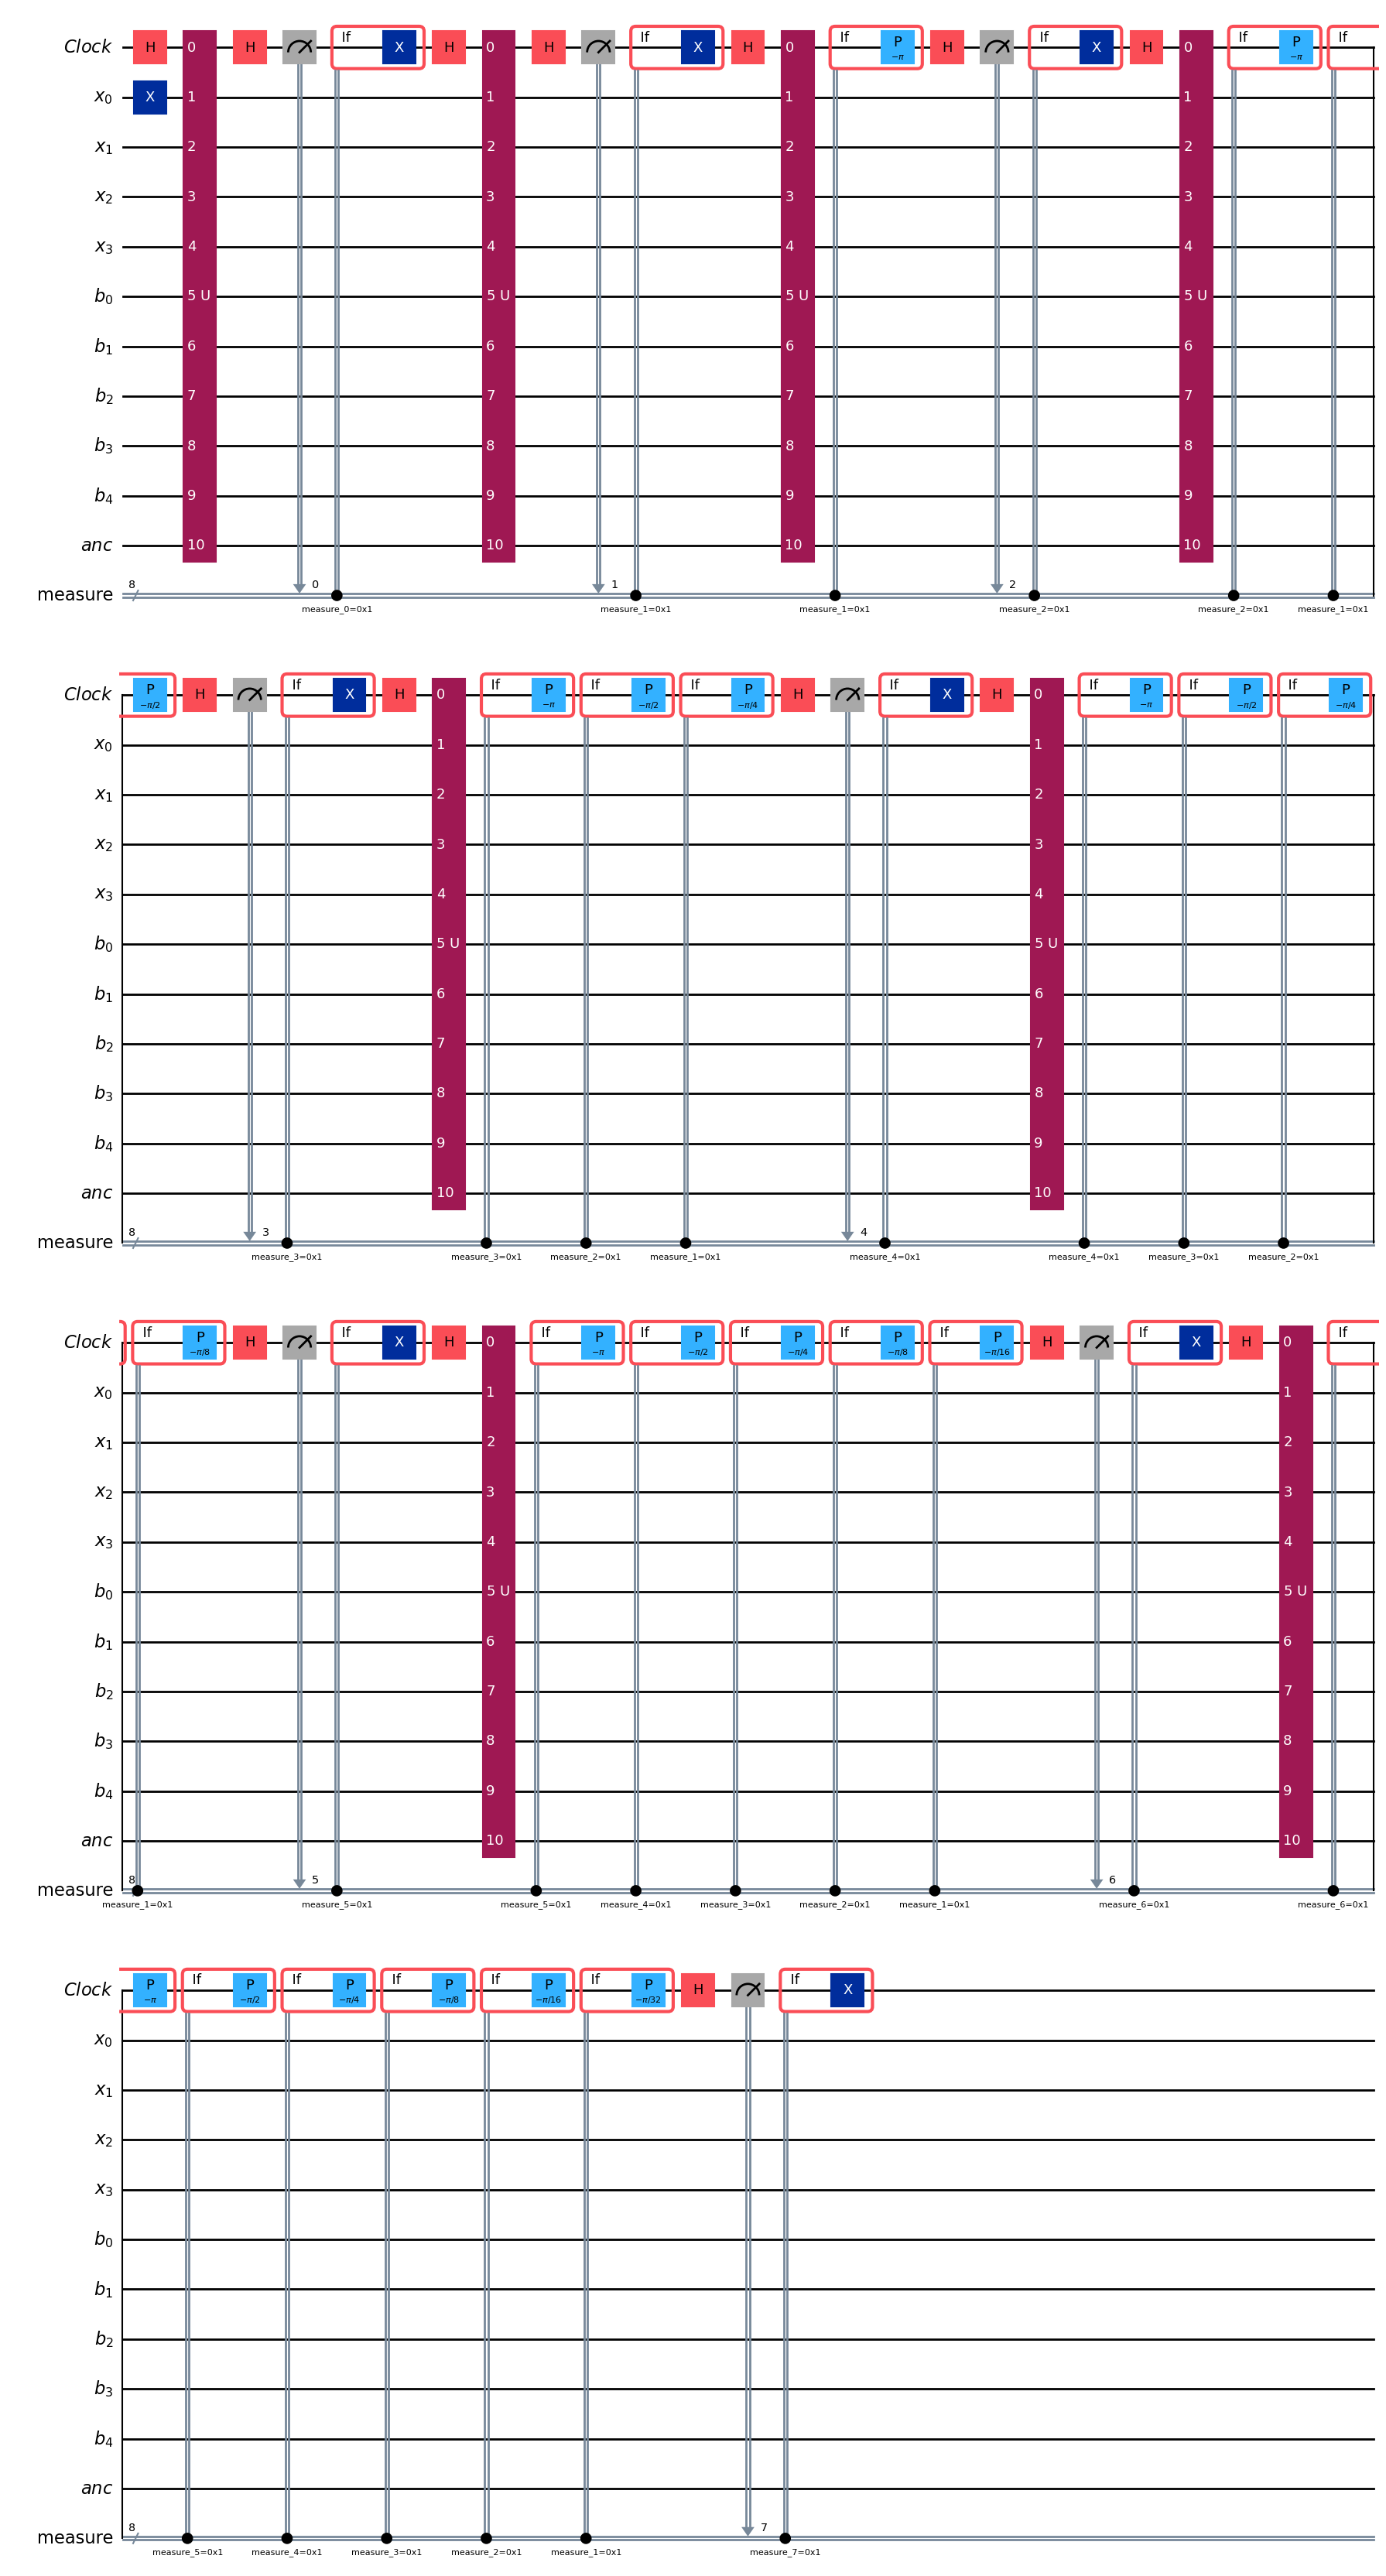

In [23]:
qc = Shor_Iterative_Circuit(n, a, N)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

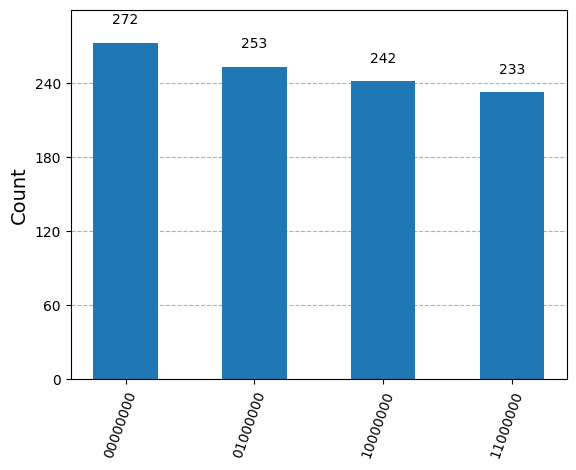

In [24]:
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = AerSimulator(device='GPU', max_parallel_shots=1, max_parallel_threads=1)# GenericBackendV2(num_qubits=qc.num_qubits)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos el periodo.

---
# Factorizando un número.

Vamos a probar a juntar todo lo que hemos hecho para factorizar el número 33 = 3 * 11. En este caso, n=6, por lo que necesitaremos 15 qubits, algo asumible. Para ello vamos a crear una función que realice todo el algoritmo.

---
El algoritmo de Shor es un algoritmo que permite factorizar el número $N =p \cdot q$ en los números primos $p$ y $q$ en un tiempo polinómico mediante técnicas de computación cuántica.

El algoritmo procede de la siguiente manera:

### **Parte clásica**

* Elegir un número aleatorio $a$ entre $2$ y $N-1$.
* Calcular $mcd(a, N)$ (máximo común divisor).
Si $mcd(a, N) \neq 1$, este número es un factor no trivial de $N$ y hemos acabado.
* Si $mcd(a, N) = 1$, usamos la parte cuántica para encontrar r, el período de la función:
$f(x)=a^{x}{\bmod {N}}$.
* Este r es el entero positivo más pequeño r para el cual $f(x+r)=f(x)$.
* Si r es impar, volvemos al paso 1 (porque necesitamos su mitad).
* Si $a^{r/2} = -1({\bmod {N}})$, volvemos al paso 1.
Sino, ambos $mcd(a^{r/2}+1,N)$ y $mcd(a^{r/2}-1,N)$ son factores no triviales de N, los primos que queremos.

### **Parte Cuántica**
Hay 2 posibilidades que estudiaremos más adelante, pero conceptualmente se basa en estudiar los autovalores del operador $U_a$ que nos convierte $|x\rangle$ en $|(a\cdot x)mod(N)\rangle$. Este operador unitario introduce una fase en dichos estados, la cual podemos medir con métodos de quantum phase estimation y nos permite obtener la periodicidad de la función $f(y)=a^{y}{\bmod {N}}$.

La idea reside en que vamos a calcular con una superposición de estados que entrelazaremos con el autoestado.

Como vamos a estudiar $f(y)=a^{y}{\bmod {N}}$, haremos que el estado de entrada sea $|1\rangle$, ya que es el autoestado de este operador.

In [25]:
def factorizador(p,q, n_intentos=10):
    #Para el numero de qubits
    a, N = primador(p, q, used_a = [])
    n = int(np.ceil(np.log2(N)))
    print('n=', n)
    #Número de shots
    n_shots = 20
    #Simulador de 2n+3 qubits
    backend = AerSimulator(device='GPU', max_parallel_shots=0, max_parallel_threads=0)#GenericBackendV2(num_qubits=2*n+3)

    used_a = []
    #Buscamos a
    for i in range(n_intentos):
        a, N = primador(p, q, used_a = used_a)
        used_a.append(a)
        #Hacemos el circuito
        qc = Shor_Iterative_Circuit(n, a, N)

        #Transpilamos
        qc_transpiled = transpile(qc, backend)

        #Creamos el job con más shots para más precisión
        job = backend.run(qc_transpiled, shots=n_shots)

        #Obtenemos el resultado y sus cuentas
        counts = job.result().get_counts()

        #Procesamos la salida
        p_obt, q_obt = procesador(counts, a, n, N)

        if (p_obt != 1 and p_obt != N) or (q_obt != 1 and q_obt != N):#Paramos
            print(f'\rIntentos necesitados: {i+1}. a = {a}')
            return p_obt, q_obt
            break
        else:
            print(f'\rIteración {i} fallida. a={a}', end='')

Lo probamos.

In [26]:
p = 3
q = 5

p_obt, q_obt = factorizador(p,q)

n= 4
Iteración 0 fallida. a=4
r =  4 , salida de cuentas:  64 . Puesto:  2
Los primos son:  3 ,  5
Intentos necesitados: 2. a = 8


In [27]:
p = 3
q = 7

p_obt, q_obt = factorizador(p,q)

n= 5

r =  16 , salida de cuentas:  512 . Puesto:  7
Los primos son:  3 ,  7
Intentos necesitados: 1. a = 10


In [28]:
p = 5
q = 7

p_obt, q_obt = factorizador(p,q)

n= 6

r =  16 , salida de cuentas:  1024 . Puesto:  5
Los primos son:  5 ,  7
Intentos necesitados: 1. a = 23


---
# Ejercicio avanzado

Prueba a factorizar el número 187 (11*17). Requiere n= 8, un total de 19 qubits para el algoritmo. También puedes probar con 713 (23*31), que son n=10, 23 qubits.

In [29]:
p = 11
q = 17

p_obt, q_obt = factorizador(p,q)

n= 8

r =  16 , salida de cuentas:  4096 . Puesto:  2
Los primos son:  17 ,  11
Intentos necesitados: 1. a = 62


In [ ]:
p = 23
q = 31

p_obt, q_obt = factorizador(p,q)

n= 10


KeyboardInterrupt: 